### Todo
- train only semi-hard
- evaluate matrix (roc, kfold)

- original paper :[here](https://arxiv.org/abs/1503.03832)
- code [pytorch](https://github.com/tbmoon/facenet) convert of [(1) pytorch](https://github.com/liorshk/facenet_pytorch) and [(2) tf](https://github.com/davidsandberg/facenet)
- dataset [here](http://vis-www.cs.umass.edu/lfw/), paper claims that they got 99.63% acc, cuts the error rate in comparison to the best published result [15] by 30%
- inspired by n [19] in the context of nearest-neighbor classification



**definition**
- online/offline
    - Generate triplets offline: find argmax/argmin (positive/negative) every n steps
    - Generate triplets online: "-------------------------------------" within a mini-batch
<br>

**Implementation (based on paper)**
- ensured that a minimal number of exemplars of any one identity is present in each mini-batch
- all anchor positive pairs in a mini-batch while still selecting the **hard** negatives. (They claim, it's more stable than with both **hard** neg&pos)
- hardest negatives can lead to local minima early on in training
- select semi-hard, argmin(f(x)) that still more than positive

- Stochastic Gradient Descent (SGD) with standard backprop and AdaGrad 
- start with a learning rate of 0.05, and lower over time
- margin α is set to 0.2
- use rectified linear units
- Input sizes range from 96x96 pixels to 224x224

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner

%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def random_dict(dict_obj):
    key = random.choice(list(dict_obj))
    return dict_obj[key]
def random_except(arr, except_value):
    random_value = random.choice(arr)
    if random_value == except_value:
        return random_except(arr, except_value)
    return random_value
class OneShotDataset(Dataset):
    
    def __init__(self, dataset, max_num_each_class=10):
        self.class_dict = {}
        self.dataset = dataset
        num_each_class = {}
        length = 0
        self.all_data = []
        
        for i, (data, label) in enumerate(self.dataset):
            label_item = label.item()
            if label_item not in list(self.class_dict.keys()):
                self.class_dict[label_item] = []
                num_each_class[label_item] = 0
                
            if max_num_each_class is -1 or num_each_class[label_item] < max_num_each_class:
                self.class_dict[label_item].append((data, label))
                num_each_class[label_item] += 1
                length += 1
        
        for i in range(length):
            self.all_data.append(self.gen_data())
                
    def gen_data(self):
        # anchor
        image_anchor, class_anchor_tensor = random.choice(random_dict(self.class_dict))
        class_anchor = class_anchor_tensor.item()
        
        # positive
        image_positive, class_positive_tensor = random.choice(self.class_dict[class_anchor])
        if image_positive is image_anchor:
            # rerandom if anchor and positive are the same
            image_positive, class_positive_tensor = random.choice(self.class_dict[class_anchor])
            
        # negative
        class_negative = random_except(list(self.class_dict), class_anchor)
        image_negative, class_negative_tensor = random.choice(self.class_dict[class_negative])
        return image_anchor, image_positive, image_negative
        
    def __getitem__(self, index):
        return self.all_data[index]
        
    def __len__(self):
        return len(self.all_data)

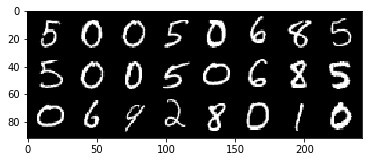

In [3]:
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transforms.ToTensor()))
data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, num_workers=8)
example_batch = next(iter(data_loader_test))


concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()


In [18]:
transform_train = transforms.Compose([
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = OneShotDataset(datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train), max_num_each_class=50)
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transform_test))
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)


In [19]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.Linear(500, 10)
        )
        self.is_classification = True
        
    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc(output)
        return output

    def forward(self, input_anchor, input_positive, input_negative):
        output1 = self.forward_once(input_anchor)
        output2 = self.forward_once(input_positive)
        output3 = self.forward_once(input_negative)
        return output1, output2, output3
    def name(self):
        return "LeNetOneShot"

In [20]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist   = F.pairwise_distance(anchor, positive)
        neg_dist   = F.pairwise_distance(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss

In [107]:
margin = 0.2
criterion = TripletLoss(margin).to(device)
def model_loss_func(input_data, model, phase):
    input_anchor, input_positive, input_negative = input_data
    output_anchor, output_positive, output_negative = model(input_anchor, input_positive, input_negative)
    
    if phase=='train':
        # train only semi-hard
        distance_positive = F.pairwise_distance(output_anchor, output_positive)
        distance_negative = F.pairwise_distance(output_anchor, output_negative)
        mask_hard = distance_negative < distance_positive+margin
        num_hard = mask_hard.sum()
        print('num_hard:', num_hard.item())
        if num_hard == 0:
            return 0, 0, 'skip' # if return the third params means skip update weight
        output_anchor = output_anchor[mask_hard]
        output_positive = output_positive[mask_hard]
        output_negative = output_negative[mask_hard]
        #-----------------------------------
    
    
    loss = criterion(output_anchor, output_positive, output_negative)
    return (output_anchor, output_positive, output_negative), loss

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [108]:
model = LeNetOneShot()

def eval_func(input_data, output, loss):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
num_hard: 128
num_hard: 95
num_hard: 42
num_hard: 41
   [train] Average loss: 0.1580, acc: 39.40%
   [test] Average loss: 0.0542, acc: 91.00%
---- epoch:1 ------
num_hard: 27
num_hard: 19
num_hard: 20
num_hard: 27
   [train] Average loss: 0.1451, acc: 11.80%
   [test] Average loss: 0.0515, acc: 88.00%
---- epoch:2 ------
num_hard: 16
num_hard: 17
num_hard: 15
num_hard: 10
   [train] Average loss: 0.1193, acc: 8.00%
   [test] Average loss: 0.0530, acc: 90.00%
---- epoch:3 ------
num_hard: 7
num_hard: 14
num_hard: 11
num_hard: 8
   [train] Average loss: 0.1029, acc: 6.80%
   [test] Average loss: 0.0536, acc: 89.00%
---- epoch:4 ------
num_hard: 4
num_hard: 2
num_hard: 4
num_hard: 6
   [train] Average loss: 0.0872, acc: 2.80%
   [test] Average loss: 0.0533, acc: 88.00%
---- epoch:5 ------
num_hard: 2
num_hard: 1
num_hard: 3
num_hard: 0
   [train] Average loss: 0.0621, acc: 1.00%
   [test] Average loss: 0.0515, acc: 88.00%
---- epoch:6 ------
num_hard: 0
num_hard: 1
num

### Finding threshod

In [109]:
def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        return (positive_distance < negative_distance).sum().item()
learner.predict(model_loss_func, eval_func)

   [test] Average loss: 0.0414, acc: 93.00%


In [110]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        
        # positive
        positive_distance = F.pairwise_distance(anchor, positive)
        positive_correct = positive_distance<threshold
        
        # negative
        negative_distance = F.pairwise_distance(anchor, negative)
        negative_correct = negative_distance>threshold
        return (positive_correct+negative_correct).sum().item()/2
    learner.predict(model_loss_func, eval_func)

In [114]:
for threshold in np.arange(0.8, 1.5, .01):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.8
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.81
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8200000000000001
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8300000000000001
   [test] Average loss: 0.0414, acc: 80.50%
threshold: 0.8400000000000001
   [test] Average loss: 0.0414, acc: 81.00%
threshold: 0.8500000000000001
   [test] Average loss: 0.0414, acc: 81.50%
threshold: 0.8600000000000001
   [test] Average loss: 0.0414, acc: 81.50%
threshold: 0.8700000000000001
   [test] Average loss: 0.0414, acc: 82.50%
threshold: 0.8800000000000001
   [test] Average loss: 0.0414, acc: 82.50%
threshold: 0.8900000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9000000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9100000000000001
   [test] Average loss: 0.0414, acc: 83.50%
threshold: 0.9200000000000002
   [test] Average loss: 0.0414, acc: 83.00%
threshold: 0.9300000000000002
   [test] Average loss: 0.0414, acc: 

In [115]:
predict_with_threshold(1.0300000000000002)

   [test] Average loss: 0.0414, acc: 87.00%
